# Model Evaluation

**The goal of the this notebook is to evaluate the models that result from applying different combinations of the four extensions to the original model.**

**Main conclusion:** The model that includes the four extensions performs best.

**Conventions**

1. 2D: Includes flatten sequence in two directions.
2. Bi: Includes bidirectional RNN.
3. attn: Includes 1 head of an attention mechanism.
4. prob/energy: Whether the model calculates the loss on the probability of the sequence's elements or directly on the energy.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.energy_models import (EnergyRNN, EnergyRNN2D,
                                  EnergyAttentionRNN, EnergyAttentionRNN2D)
from models.probability_models import (ProbabilityRNN, ProbabilityRNN2D,
                                       ProbabilityAttentionRNN, ProbabilityAttentionRNN2D)
from data_utils.pytorch_datasets import EnergyDataset2D

## Data Loaders

In [2]:
train_data_path = './data/eval_data.hdf5'
batch_size = 128
n_random_samples = 32000

energy_dataset_2D = EnergyDataset2D(filepath=train_data_path)
random_sampler_2D = RandomSampler(energy_dataset_2D, num_samples=n_random_samples, replacement=True)
energy_loader_2D = DataLoader(
    energy_dataset_2D,
    batch_size=batch_size,
    sampler=random_sampler_2D,
    num_workers=0)

## Energy Models Initialization

In [3]:
energy_rnn_base = './model_weights/energy/rnn'
energy_attn_base = './model_weights/energy/rnn_attn'
energy_rnn_paths = {model: os.path.join(energy_rnn_base, model, 'model.ckpt') 
                     for model in os.listdir(energy_rnn_base)}
energy_attn_paths = {model: os.path.join(energy_attn_base, model, 'model.ckpt') 
                      for model in os.listdir(energy_attn_base)}

In [4]:
energy_rnn_models = {}
energy_attn_models = {}
for model, path in energy_rnn_paths.items():
    if '2D' in model:
        energy_rnn_models[model] = EnergyRNN2D.load_from_checkpoint(path).eval()
    else:
        energy_rnn_models[model] = EnergyRNN.load_from_checkpoint(path).eval()
        
for model, path in energy_attn_paths.items():
    if '2D' in model:
        energy_attn_models[model] = EnergyAttentionRNN2D.load_from_checkpoint(path).eval()
    else:
        energy_attn_models[model] = EnergyAttentionRNN.load_from_checkpoint(path).eval()

## Probability Models Initilization

In [5]:
prob_rnn_base = './model_weights/probability/rnn'
prob_attn_base = './model_weights/probability/rnn_attn'
prob_rnn_paths = {model: os.path.join(prob_rnn_base, model, 'model.ckpt') 
                     for model in os.listdir(prob_rnn_base)}
prob_attn_paths = {model: os.path.join(prob_attn_base, model, 'model.ckpt') 
                      for model in os.listdir(prob_attn_base)}

In [6]:
prob_rnn_models = {}
prob_attn_models = {}
for model, path in prob_rnn_paths.items():
    if '2D' in model:
        prob_rnn_models[model] = ProbabilityRNN2D.load_from_checkpoint(path).eval()
    else:
        prob_rnn_models[model] = ProbabilityRNN.load_from_checkpoint(path).eval()
        
for model, path in prob_attn_paths.items():
    if '2D' in model:
        prob_attn_models[model] = ProbabilityAttentionRNN2D.load_from_checkpoint(path).eval()
    else:
        prob_attn_models[model] = ProbabilityAttentionRNN.load_from_checkpoint(path).eval()

## Generate Predictions

In [7]:
energy_rnn_preds = defaultdict(list)
energy_attn_preds = defaultdict(list)
prob_rnn_preds = defaultdict(list)
prob_attn_preds = defaultdict(list)
true_energy = []
with torch.no_grad():
    for x_row, x_col, y in tqdm(energy_loader_2D):
        for model_name, model in energy_attn_models.items():
            if '2D' in model_name:
                y_pred, _ = model(x_row, x_col)
            else:
                y_pred, _ = model(x_row)
            energy_attn_preds[model_name].append(y_pred)
                
        for model_name, model in energy_rnn_models.items():
            if '2D' in model_name:
                y_pred = model(x_row, x_col)
            else:
                y_pred = model(x_row)
            energy_rnn_preds[model_name].append(y_pred)
            
        for model_name, model in prob_attn_models.items():
            if '2D' in model_name:
                y_pred = model.predict_energy(x_row, x_col)
            else:
                y_pred = model.predict_energy(x_row)
            prob_attn_preds[model_name].append(y_pred)
                
        for model_name, model in prob_rnn_models.items():
            if '2D' in model_name:
                y_pred = model.predict_energy(x_row, x_col)
            else:
                y_pred = model.predict_energy(x_row)
            prob_rnn_preds[model_name].append(y_pred)
        
        true_energy.append(y)

In [8]:
def center_predictions(preds_list):
    preds_tensor = torch.cat(preds_list, axis=0)
    return (preds_tensor - torch.mean(preds_tensor)).squeeze()

In [9]:
centered_energy_rnn_preds = {}
centered_energy_attn_preds = {}
centered_prob_rnn_preds = {}
centered_prob_attn_preds = {}

for model, model_preds in energy_rnn_preds.items():
    centered_energy_rnn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in energy_attn_preds.items():
    centered_energy_attn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in prob_rnn_preds.items():
    centered_prob_rnn_preds[model] = center_predictions(model_preds)
    
for model, model_preds in prob_attn_preds.items():
    centered_prob_attn_preds[model] = center_predictions(model_preds)
    
true_centered = center_predictions(true_energy)

## RMSE Calculation

In [10]:
criterion = nn.MSELoss()
rmse_values = {}
for model, model_preds in centered_energy_rnn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['energy_rnn/' + model] = rmse.item()
    
for model, model_preds in centered_energy_attn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['energy_attn/' + model] = rmse.item()
    
for model, model_preds in centered_prob_rnn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['prob_rnn/' + model] = rmse.item()
    
for model, model_preds in centered_prob_attn_preds.items():
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    rmse_values['prob_attn/' + model] = rmse.item()

### Model Leaderboard

In [11]:
leaderboard = {k: v for k, v in sorted(rmse_values.items(), key=lambda item: item[1])}
for i, (model, score) in enumerate(leaderboard.items()):
    print(f'{i+1}. {model}: {score:.2f}')

1. energy_attn/2D_GRU_1L_1H_Bi: 7.79
2. energy_attn/GRU_1L_1H_Bi: 11.26
3. energy_attn/GRU_1L_1H: 12.71
4. energy_rnn/2D_GRU_1L_Bi: 12.72
5. energy_rnn/GRU_1L_Bi: 13.64
6. energy_rnn/2D_GRU_1L: 14.21
7. energy_rnn/LSTM_1L_Bi: 14.27
8. energy_rnn/GRU_1L: 15.78
9. prob_rnn/GRU_1L: 19.85
10. prob_rnn/2D_GRU_1L: 20.03
11. prob_attn/2D_GRU_1L_1H: 22.16
12. prob_rnn/2D_GRU_1L_Bi: 22.50
13. prob_rnn/GRU_1L_Bi: 23.97
14. prob_rnn/LSTM_1L_Bi: 24.01
15. prob_attn/2D_GRU_1L_1H_Bi: 24.60
16. prob_attn/GRU_1L_1H_Bi: 25.72


## Plot Model Generalization

In [12]:
def plot_difference(true_centered, model_centered_preds, ax, label, delta=False):

    diffs = model_centered_preds - true_centered
    buckets = defaultdict(list)
    for true, pred in zip(true_centered, diffs):
        buckets[true].append(pred)

    n_buckets = len(buckets)
    y_high = np.zeros(n_buckets)
    y_center = np.zeros(n_buckets)
    y_low = np.zeros(n_buckets)
    x_vals = np.zeros(n_buckets)
    for i, key in enumerate(sorted(buckets.keys())):
        x_vals[i] = key
        diffs_arr = np.array(buckets[key])
        mean = np.mean(diffs_arr)
        std = np.std(diffs_arr)
        y_low[i] = mean - 2*std
        y_center[i] = mean
        y_high[i] = mean + 2*std
        
    if delta:
        ax.fill_between(x_vals, y_high, y_low, alpha=0.2)
    ax.plot(x_vals, y_center, label=label)

Text(0.5, 0, '$E(\\sigma_{i}) - \\overline{E(\\sigma)}$')

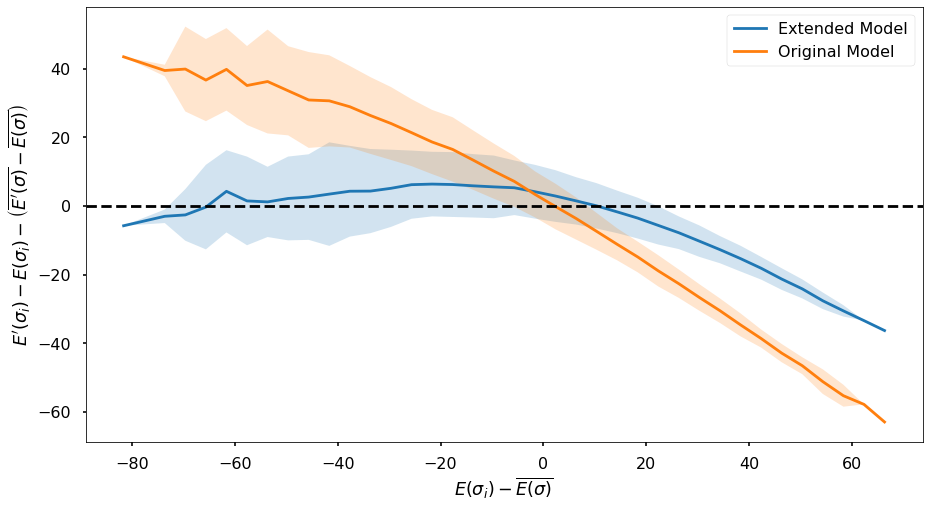

In [13]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(figsize=(15, 8))
delta = True

best_model = '2D_GRU_1L_1H_Bi'
best_preds = centered_energy_attn_preds[best_model]
ref_model = 'GRU_1L'
ref_preds = centered_prob_rnn_preds[ref_model]

plot_difference(true_centered.numpy(), best_preds.numpy(), ax, 'Extended Model', delta)
plot_difference(true_centered.numpy(), ref_preds.numpy(), ax, 'Original Model', delta)
ax.legend()
ax.axhline(0, linestyle='--', c='black')
ax.set_ylabel(r"${E}'(\sigma_{i}) - E(\sigma_{i})- \left(\overline{{E}'(\sigma)} - \overline{E(\sigma)}\right)$")
ax.set_xlabel(r"$E(\sigma_{i}) - \overline{E(\sigma)}$")